Objective : Recommending electronic product in the e-commerce platform

In [ ]:
!pip install surprise

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline

from sklearn.model_selection import train_test_split

from surprise import NormalPredictor, BaselineOnly, CoClustering, KNNWithMeans, KNNBasic, KNNWithZScore, KNNBaseline, SVD, SVDpp, SlopeOne, NMF
from surprise import Dataset
from surprise import accuracy
from surprise import Reader

import os
from surprise.model_selection import train_test_split, cross_validate
from collections import defaultdict


Data Loading

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Electronics/ratings_Electronics.csv', names=['userId', 'productId','rating','timestamp'])

In [ ]:
data.head()

,userId,productId,rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     object 
 1   productId  object 
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB


In [ ]:
data.rating.describe()

count    7.824482e+06
mean     4.012337e+00
std      1.380910e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

In [ ]:
data.drop('timestamp', axis=1,inplace=True)

In [ ]:
data.shape

(7824482, 3)

In [ ]:
# sample 10% of the data for easier processing
data1 = data.sample(frac=0.1, random_state=123)
data1.shape

(782448, 3)

EDA

In [ ]:
fig = px.histogram(data1, x="rating", width=600, height=500).update_layout(bargroupgap=0.2) 
fig.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
data1.head()

,userId,productId,rating
1254301,A168K67WGLNVEI,B000OKH75M,2.0
6691256,A3D4WPAEPIDJJI,B009QMZ7SS,5.0
4695620,A3BP4V04FIRIZT,B0054QJ2BS,5.0
1659195,A1MFBCGSTTV1NX,B001407E86,3.0
170608,A1VNV8Q57V8TS4,B00006B7DB,5.0


In [ ]:
# rating per productid all 
data1.groupby('productId')['rating'].count().reset_index().sort_values('rating', ascending=False).head()

,productId,rating
115321,B0074BW614,1892
154610,B00DR0PDNE,1652
121837,B007WTAJTO,1400
40518,B0019EHU8G,1235
69433,B003ELYQGG,1201


In [ ]:
#rating dist by product clipped at 50 ratings

ratingperproduct = data1.groupby('productId')['rating'].count().clip(upper=50)
ratingperproduct = ratingperproduct.reset_index()

fig = px.histogram(ratingperproduct, x="rating", width=600, height=500, title='number of rating distribution per product').update_layout(bargroupgap=0.2) 
fig.show()


In [ ]:
# rating per userid all 

data1.groupby('userId')['rating'].count().reset_index().sort_values('rating', ascending=False).head()

,userId,rating
522609,A5JLAU2ARJ0BO,54
479064,A3OXHLG6DIBRW8,54
527049,A6FIAB28IS79,49
562355,ADLVFFE4VBT8,49
526025,A680RUE1FDO8B,42


In [ ]:
#rating dist by user 

ratingperuser = data1.groupby('userId')['rating'].count()
ratingperuser = ratingperuser.reset_index()

fig = px.histogram(ratingperuser, x="rating", width=600, height=500, title='number of rating distribution per user').update_layout(bargroupgap=0.2) 
fig.show()



In order to reduce the sparsity of the data and avoid memory error, only customers that have given rating >= 20 times are considered)

In [ ]:
#Keep the customer where the customer has rated more than 20 times

counts1 = data1['userId'].value_counts()
data_new = data1[data1['userId'].isin(counts1[counts1 >= 20].index)]


In [ ]:
data_new.userId.nunique()

57

In [ ]:
data_new.sort_values('rating', ascending=False).head()

,userId,productId,rating
6310155,A18HE80910BTZI,B008O0XSRA,5.0
3734681,AEJAGHLC675A7,B003ZYF3M8,5.0
6516218,A6FIAB28IS79,B0097BEF1S,5.0
4119390,A36K2N527TXXJN,B004GW25WY,5.0
1860913,A1F7YU6O5RU432,B001AW8W7A,5.0


In [ ]:
#highest rated products from the selected records. 

top20product = data_new.groupby('productId')['rating'].mean().sort_values(ascending=False).reset_index().head(20)

In [ ]:
fig = px.bar(top20product, x='rating', y='productId',width=600, height=500, title='top 20 rated best product')
fig.show()

Popularity based recommendation for cold start customers (no history of preferences). <br>
Note that the recommendation will be the same across the users

In [ ]:
#Calculate the density of the utility rating matrix

final_ratings_matrix = data_new.pivot(index = 'userId', columns ='productId', values = 'rating').fillna(0)
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)

Shape of final_ratings_matrix:  (57, 1461)


In [ ]:
given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

given_num_of_ratings =  1548
possible_num_of_ratings =  83277
density: 1.86%


In [ ]:
final_ratings_matrix.head()

productId,B00000DM9W,B00001P4ZH,B000026D8E,B00003006R,B00003CWCI,B00003G1RJ,B00004SB92,B00004SCKA,B00004T1KZ,B00004THDE,B00004TJ7O,B00004TVSO,B00004TZJJ,B00004TZJK,B00004U4MT,B00004VV4J,B00004VWM3,B00004WLJ9,B00004X107,B00004XO1V,B00004Y303,B00004Y7T3,B00004Z5PY,B00004Z86J,B0000511T7,B000056SRE,B00005ARK3,B00005B6TI,B00005BKZZ,B00005ICE1,B00005ICE3,B00005JGFK,B00005LB8P,B00005LDK6,B00005MA9X,B00005N6KF,B00005NDUP,B00005NIMR,B00005NPWJ,B00005OAY3,...,B00ITZQGT2,B00IVPU6AA,B00IWJUGQY,B00IX2HC6C,B00IX2VGFA,B00IX6D0EQ,B00IYXP9HE,B00IZGWTVO,B00J0CVVGQ,B00J0XR10A,B00J238GV6,B00J2KEVZY,B00J5174TU,B00J54NXH4,B00J5HDEPC,B00JC31SGG,B00JC5Y6WM,B00JGGBBBG,B00JGGUBPI,B00JGGV15C,B00JKCH4X0,B00JL8OYRM,B00JOS04PK,B00JWV1LP6,B00JWXNT2M,B00JWXTOIA,B00JXUUVWU,B00K6B7KJM,B00KD3EW4O,B00KFAGCUM,B00KIMX4EY,B00KINSDK8,B00KJJW36G,B00KLGSQJ0,B00KNEBRT6,B00KVNY2KA,B00KWMNDDM,B00KYA7CT8,B00L1I727Y,B00L3YHF6O
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A11I1I9QLMAM1A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A12DQZKRKTNF5E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A17BUUBOU0598B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A18HE80910BTZI,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1EVV74UQYVKRY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Matrix with one row per 'Product' and one column per 'user' for Item-based CF

final_ratings_matrix_T = final_ratings_matrix.transpose()
final_ratings_matrix_T.head()

userId,A11I1I9QLMAM1A,A12DQZKRKTNF5E,A17BUUBOU0598B,A18HE80910BTZI,A1EVV74UQYVKRY,A1F1A0QQP2XVH5,A1F7YU6O5RU432,A1F9Z42CFF9IAY,A1ODOGXEYECQQ8,A1T1YSCDW0PD25,A1UQBFCERIP7VJ,A1VQHH85U7PX0,A203OCQQ12MAVT,A225G2TFM76GYX,A22CW0ZHY3NJH8,A231WM2Z2JL0U3,A23GFTVIETX7DS,A250AXLRBVYKB4,A25C2M3QF9G7OQ,A25HBO5V8S8SEA,A2AY4YUOX2N1BQ,A2BMZRO0H7TFCS,A2BYV7S1QP2YIG,A2D1LPEUCTNT8X,A2NOW4U7W3F7RI,A2NYK9KWFMJV4Y,A2UOHALGF2X77Q,A2WB7LZ595CR50,A2XRMQA6PJ5ZJ8,A31N0XY2UTB25C,A36K2N527TXXJN,A38RMU1Y5TDP9,A3A4ZAIBQWKOZS,A3AYSYSLHU26U9,A3CG93783LP0FO,A3CW0ZLUO5X2B1,A3EXWV8FNSSFL6,A3FOSLM5G1BO63,A3LGT6UZL99IW1,A3OA4DV4L81N1D,A3OXHLG6DIBRW8,A3PD8JD9L4WEII,A3T7V207KRDE2O,A4WEZJOIZIV4U,A5JLAU2ARJ0BO,A680RUE1FDO8B,A6FIAB28IS79,ABQWMANK4AR63,ADLVFFE4VBT8,AEJAGHLC675A7,AEWYUPCNDV7HY,AGVWTYW0ULXHT,AN81JUYW2SL24,ARBKYIVNYWK3C,AT6CZDCP4TRGA,AVPNQUVZWMDSX,AWPODHOB4GFWL
productId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
B00000DM9W,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B00001P4ZH,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B000026D8E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B00003006R,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0
B00003CWCI,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#Count of user_id for each unique product as recommendation score 

data_new_grouped = data_new.groupby('productId').agg({'userId': 'count'}).reset_index()
data_new_grouped.rename(columns = {'userId': 'score'},inplace=True)
data_new_grouped.head()

,productId,score
0,B00000DM9W,1
1,B00001P4ZH,1
2,B000026D8E,2
3,B00003006R,1
4,B00003CWCI,1


In [ ]:
#Sort the products on recommendation score 

train_data_sort = data_new_grouped.sort_values(['score', 'productId'], ascending = [0,1]) 

In [ ]:
#Generate a recommendation rank based upon score 

train_data_sort['Rank'] = train_data_sort['score'].rank(ascending=0, method='first')

In [ ]:
#Get the top 5 recommendations 

popularity_recommendations = train_data_sort.head(5) 
popularity_recommendations 

,productId,score,Rank
433,B00169N0BK,3,1.0
607,B002KC55OM,3,2.0
798,B004CLYEDC,3,3.0
870,B0053R0WWG,3,4.0
962,B0061GQ7PO,3,5.0


In [ ]:
# Use popularity based recommender model to make predictions 

def recommend(user_id):     
    user_recommendations = popularity_recommendations 
          
    #Add user_id column for which the recommendations are being generated 
    user_recommendations['userId'] = user_id 
    
    #Bring user_id column to the front 
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations 

In [ ]:
find_recom = ['A12DQZKRKTNF5E','A15QYHQH80W30L','A17BUUBOU0598B']
for userid in find_recom:
    print("Here is the recommendation for the userId: "+ userid)
    print(recommend(userid))    
    print("\n") 

Here is the recommendation for the userId: A12DQZKRKTNF5E
             userId   productId  score  Rank
433  A12DQZKRKTNF5E  B00169N0BK      3   1.0
607  A12DQZKRKTNF5E  B002KC55OM      3   2.0
798  A12DQZKRKTNF5E  B004CLYEDC      3   3.0
870  A12DQZKRKTNF5E  B0053R0WWG      3   4.0
962  A12DQZKRKTNF5E  B0061GQ7PO      3   5.0


Here is the recommendation for the userId: A15QYHQH80W30L
             userId   productId  score  Rank
433  A15QYHQH80W30L  B00169N0BK      3   1.0
607  A15QYHQH80W30L  B002KC55OM      3   2.0
798  A15QYHQH80W30L  B004CLYEDC      3   3.0
870  A15QYHQH80W30L  B0053R0WWG      3   4.0
962  A15QYHQH80W30L  B0061GQ7PO      3   5.0


Here is the recommendation for the userId: A17BUUBOU0598B
             userId   productId  score  Rank
433  A17BUUBOU0598B  B00169N0BK      3   1.0
607  A17BUUBOU0598B  B002KC55OM      3   2.0
798  A17BUUBOU0598B  B004CLYEDC      3   3.0
870  A17BUUBOU0598B  B0053R0WWG      3   4.0
962  A17BUUBOU0598B  B0061GQ7PO      3   5.0




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

In [ ]:
data_new.shape

(1548, 3)

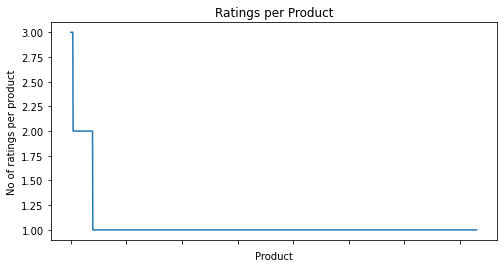

In [ ]:
no_of_ratings_per_product = data_new.groupby(by='productId')['rating'].count().sort_values(ascending=False)

fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(no_of_ratings_per_product.values)
plt.title('Ratings per Product')
plt.xlabel('Product')
plt.ylabel('No of ratings per product')
ax.set_xticklabels([])

plt.show()

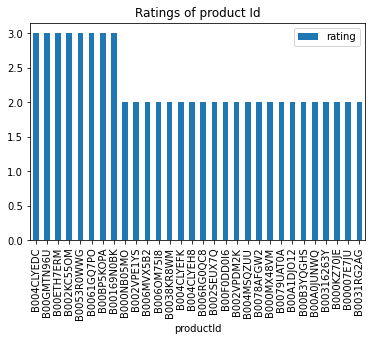

In [ ]:
# Top 30 recommendations for the users based on rating (alternative to popularity)

popular_products = pd.DataFrame(data_new.groupby('productId')['rating'].count())
most_popular = popular_products.sort_values('rating', ascending=False)
most_popular.head(30).plot(kind = "bar")
plt.title("Ratings of product Id")
plt.show()

Collaborative Filtering (user based and Item based) for existing customer who already have history of preferences <br>
The recommendation will be personalized based on their past preferences

In [ ]:
data_new.head()

,userId,productId,rating
5101374,A17BUUBOU0598B,B005NFG1MS,4.0
2592086,AWPODHOB4GFWL,B002GXIT6Q,4.0
2019229,A18HE80910BTZI,B001FSIT9K,4.0
3601721,A680RUE1FDO8B,B003VAK1I2,5.0
7629732,A3A4ZAIBQWKOZS,B00FF6J532,5.0


In [ ]:
reader = Reader(rating_scale=(1, 5))
data_ready = Dataset.load_from_df(data_new,reader)
data_ready

In [ ]:
#benchmark many algorithm 

benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    # Perform cross validation
    results = cross_validate(algorithm, data_ready, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')    

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...


,test_rmse,fit_time,test_time
Algorithm,,,
SVDpp,0.907261,0.363746,0.007499
KNNBaseline,0.911623,0.006178,0.004372
SVD,0.914247,0.064065,0.003979
BaselineOnly,0.915205,0.003954,0.004865
CoClustering,0.931067,0.123458,0.003572
KNNWithMeans,0.939123,0.003131,0.004389
KNNWithZScore,0.943479,0.006400,0.005201
SlopeOne,0.944049,0.033878,0.004713
KNNBasic,0.944307,0.001401,0.004406


In [ ]:
print('Using SVDpp')
algo = SVDpp()
cross_validate(algo, data_ready, measures=['RMSE'], cv=3, verbose=False)

Using SVDpp


{'fit_time': (1.0948143005371094, 1.7017664909362793, 0.696040153503418),
 'test_rmse': array([0.90414981, 0.92596867, 0.89011187]),
 'test_time': (0.03320741653442383, 0.03480815887451172, 0.00962972640991211)}

In [ ]:
trainset, testset = train_test_split(data_ready, test_size=0.2)
algo = SVDpp()
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

RMSE: 0.9266


0.9265875744204998

In [ ]:
def get_Iu(uid):
    """ return the number of items rated by given user
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """ return number of users that have rated given item
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0
    

In [ ]:
df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = np.abs(df.est - df.rui)
best_predictions = df.sort_values(by='err')[:10]
worst_predictions = df.sort_values(by='err')[-10:]

In [ ]:
best_predictions

,uid,iid,rui,est,details,Iu,Ui,err
108,A3FOSLM5G1BO63,B004MSQZUU,4.0,4.012037,{'was_impossible': False},12,1,0.012037
4,A3T7V207KRDE2O,B000FJ4XP4,4.0,3.978792,{'was_impossible': False},15,0,0.021208
39,A2WB7LZ595CR50,B0031RG2AG,4.0,3.948212,{'was_impossible': False},16,1,0.051788
85,A3CG93783LP0FO,B005X64M2S,4.0,4.062019,{'was_impossible': False},18,1,0.062019
172,AGVWTYW0ULXHT,B00829THVO,4.0,3.935016,{'was_impossible': False},18,0,0.064984
12,AGVWTYW0ULXHT,B004M8SVGQ,4.0,3.935016,{'was_impossible': False},18,0,0.064984
261,AGVWTYW0ULXHT,B005HMO6A6,4.0,3.935016,{'was_impossible': False},18,0,0.064984
63,A5JLAU2ARJ0BO,B0000B35CK,4.0,3.914810,{'was_impossible': False},43,0,0.085190
307,A5JLAU2ARJ0BO,B00004T1KZ,4.0,3.914810,{'was_impossible': False},43,0,0.085190
183,A25HBO5V8S8SEA,B00005UPRJ,5.0,4.899581,{'was_impossible': False},19,0,0.100419


In [ ]:
worst_predictions

,uid,iid,rui,est,details,Iu,Ui,err
59,A1EVV74UQYVKRY,B000FZDIF4,2.0,4.678193,{'was_impossible': False},20,0,2.678193
51,ABQWMANK4AR63,B00EBRUGIO,1.0,3.875577,{'was_impossible': False},18,0,2.875577
33,A5JLAU2ARJ0BO,B0006I5I7G,1.0,3.914810,{'was_impossible': False},43,0,2.914810
163,AGVWTYW0ULXHT,B0030LO5CU,1.0,3.935016,{'was_impossible': False},18,0,2.935016
106,A3CG93783LP0FO,B000BZ1P3A,1.0,4.102175,{'was_impossible': False},18,0,3.102175
50,A2WB7LZ595CR50,B00846Z34K,1.0,4.176142,{'was_impossible': False},16,0,3.176142
216,A3CW0ZLUO5X2B1,B003CSW5U0,1.0,4.247743,{'was_impossible': False},17,0,3.247743
203,ADLVFFE4VBT8,B000UF3FT8,1.0,4.248297,{'was_impossible': False},37,0,3.248297
76,AWPODHOB4GFWL,B005L38YX6,1.0,4.315188,{'was_impossible': False},25,0,3.315188
295,A203OCQQ12MAVT,B0000511T7,1.0,4.620300,{'was_impossible': False},14,0,3.620300
